In [1]:
import numpy as np
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import traci
import sumolib

In [11]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.min_duration = 10
        self.max_duration=60
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.state_size, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    def select_action(self, state):
        Select action (phase duration) based on epsilon-greedy policy
        if np.random.rand() <= self.epsilon:
            Explore: Randomly select a phase duration within a predefined range
            return np.random.randint(self.min_duration, self.max_duration + 1, self.action_size)
        else:
            Exploit: Predict phase durations using the DQN model
            durations = self.model.predict(state)[0]
            return np.clip(durations, self.min_duration, self.max_duration)         


In [2]:
PCU = {
    'Car': 1,
    'truck_truck': 1.6,
    'bus_bus': 1.6,
    'MTW': 0.4,
    'veh_passenger': 0,
    'LCV': 1.1,
    'ARW': 0.5
}
edge_ids = ["327756257#0","-327756257#3","24242838#0","-1105574288#1"]
def get_lane_ids(edge_id):
    return traci.edge.getLaneNumber(edge_id)

def get_queue_length_in_terms_of_PCU(edge_id):
    
    result = 0

    lane_count = traci.edge.getLaneNumber(edge_id)
    for lane_index in range(lane_count):
        lane_id = f"{edge_id}_{lane_index}"
        vehicle_ids = traci.lane.getLastStepVehicleIDs(lane_id)
        for vehicle_id in vehicle_ids:
            vehicle_type = traci.vehicle.getTypeID(vehicle_id)
            result += PCU[vehicle_type]

    return result

def compute_delay(edge_ids):
    total_delay = 0.0
    for edge_id in edge_ids:
        lane_count = get_lane_ids(edge_id)
        for lane_index in range(lane_count):
            lane_id = f"{edge_id}_{lane_index}"
            vehicle_ids = traci.lane.getLastStepVehicleIDs(lane_id)
            
            for vehicle_id in vehicle_ids:
                total_delay += traci.vehicle.getAccumulatedWaitingTime(vehicle_id)
                
    return total_delay


In [3]:
def get_state(phase):
    queue_lengths_PCU_list = []  # List to store queue lengths of lanes
    delays = []    # List to store delay times of vehicles
    result = []
    for edge_id in edge_ids:
        current_queue_length = get_queue_length_in_terms_of_PCU(edge_id)
        result.append(current_queue_length)
    delays.append(compute_delay(edge_ids))
    queue_lengths_PCU_list.append(result)
    current_phase = traci.trafficlight.getPhase(tl_id)
    current_phase_duration = traci.trafficlight.getPhaseDuration(tl_id)
    state = np.array(result + delays + [current_phase , current_phase_duration])
    
    state = state.reshape((1, len(state)))
    return state


In [4]:
def reward_function():
    total_delay_time = 0
    total_queue_length=0
    for edge_id in edge_ids:
        total_queue_length+= get_queue_length_in_terms_of_PCU(edge_id)

    total_delay_time= compute_delay(edge_ids)

    # Penalty for queue length and delay time (weighted manner)

    k=0.1
    m=0.01
    
    queue_penalty = -k * total_queue_length
    delay_penalty = -m * total_delay_time
    
    # Combine penalties to form final reward
    reward = queue_penalty + delay_penalty
    return reward

In [5]:
tl_id='cluster_11391719663_11391719667_11391735232_11391735240_#1more'

In [6]:

def give_durations(tl_id): 
    duration=[]
    logic= traci.trafficlight.getCompleteRedYellowGreenDefinition(tl_id)
    # print(logic)
    Phases= logic[0].phases
    for phase in Phases:
        duration.append(phase.duration)
    # traci.close()    
    return duration

In [ ]:
print(give_durations(tl_id))

In [7]:
def change_durations(tl_id,new_dur,phase_index):
   
    logic= traci.trafficlight.getCompleteRedYellowGreenDefinition(tl_id)
    # print(logic,"\n")
    Phases= logic[0].phases
    Phases_list= list(Phases)
#     for i in range(5):
#         Phases_list[i].duration = new_dur[i]
    Phases_list[phase_index].duration=new_dur
    modified_Phases= tuple(Phases_list)
    logic[0].phases= modified_Phases
    # print(logic,"\n")
    traci.trafficlight.setProgramLogic(tl_id,logic[0])
    print(traci.trafficlight.getCompleteRedYellowGreenDefinition(tl_id),"\n")
#     traci.trafficlight.setPhase(tl_id,0)
    # print(traci.trafficlight.getPhaseDuration(tl_id))
    
    # traci.close()    

In [25]:
# Prediction

final_reward=[]
times = []
queue_lengths_PCU_list = []
delays = []
if __name__ == "__main__":
    # sumoBinary = "C:/Program Files (x86)/Eclipse/Sumo/bin/sumo-gui.exe"
    # sumoCmd = [sumoBinary, "-c", "C:/Users/DELL/Sumo/2024-04-04-19-33-39/osm.sumocfg"]
    # traci.start(sumoCmd)
    state_size=7
    # print(init_state.shape) # Define your state size based on the observations
    action_size = 1 # Define the number of actions (e.g., changing traffic light phases)
    agent = DQNAgent(state_size, action_size)
    batch_size = 32
    sumoBinary = "C:/Program Files (x86)/Eclipse/Sumo/bin/sumo-gui.exe"
    sumoCmd = [sumoBinary, "-c", "C:/Users/Yogeshwar/Desktop/Lab_based_project/2024-04-09-13-14-21/2024-04-09-13-14-21/osm.sumocfg"]
    traci.start(sumoCmd)
    
    # 
    for i in range(1):
        while traci.simulation.getMinExpectedNumber() > 0:
            traci.trafficlight.setPhase(tl_id,0)
            state=get_state(0)
            for phase in range(4):
                print(f'phase is {phase} \n')
                traci.trafficlight.setPhase(tl_id,phase)
                print(f'{traci.trafficlight.getPhase(tl_id)}')
                action = agent.select_action(state)
                change_durations(tl_id,int(action[0]),phase)
                for time in  range(int(action[0])):
                    traci.simulationStep()
                    result = []
    
                    current_time = traci.simulation.getTime()
                    for edge_id in edge_ids:
                        current_queue_length = get_queue_length_in_terms_of_PCU(edge_id)
                        result.append(current_queue_length)
                    queue_lengths_PCU_list.append(result)
                    delay = compute_delay(edge_ids)
                    times.append(current_time)
                    delays.append(delay)
                
                if phase<3:
                    traci.trafficlight.setPhase(tl_id,phase+1)    
                    next_state = get_state(phase+1)
                # reward = reward_function()
                # final_reward.append(reward)
                done = False

                # if(traci.simulation.getMinExpectedNumber() == 0 ):
                #     done=True
                # agent.remember(state, action[0], reward, next_state, done)
    
                print(f'state {state}  , the phase is {phase} na  nad the initial durations are {give_durations(tl_id)} , action {action} ')
                state = next_state
                    
                # if len(agent.memory) > batch_size:
                #     agent.replay(batch_size)
    traci.close()   


C:\Users\Yogeshwar\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


phase is 0 

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
(Logic(programID='0', type=0, currentPhaseIndex=0, phases=(Phase(duration=10.0, state='rrrrGGggrrrrGGgg', minDur=42.0, maxDur=42.0), Phase(duration=3.0, state='rrrryyyyrrrryyyy', minDur=3.0, maxDur=3.0), Phase(duration=42.0, state='GGggrrrrGGggrrrr', minDur=42.0, maxDur=42.0), Phase(duration=3.0, state='yyyyrrrryyyyrrrr', minDur=3.0, maxDur=3.0)), subParameter={}),) 



C:\Users\Yogeshwar\AppData\Local\Temp\ipykernel_32776\2118722290.py:3: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  logic= traci.trafficlight.getCompleteRedYellowGreenDefinition(tl_id)
C:\Users\Yogeshwar\AppData\Local\Temp\ipykernel_32776\2118722290.py:14: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  print(traci.trafficlight.getCompleteRedYellowGreenDefinition(tl_id),"\n")


state [[ 0.  0.  0.  0.  0.  0. 42.]]  , the phase is 0 na  nad the initial durations are [10.0, 3.0, 42.0, 3.0] , action [10.] 
phase is 1 

1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
(Logic(programID='0', type=0, currentPhaseIndex=1, phases=(Phase(duration=10.0, state='rrrrGGggrrrrGGgg', minDur=42.0, maxDur=42.0), Phase(duration=10.0, state='rrrryyyyrrrryyyy', minDur=3.0, maxDur=3.0), Phase(duration=42.0, state='GGggrrrrGGggrrrr', minDur=42.0, maxDur=42.0), Phase(duration=3.0, state='yyyyrrrryyyyrrrr', minDur=3.0, maxDur=3.0)), subParameter={}),) 

state [[1.6 0.  0.  0.  0.  1.  3. ]]  , the phase is 1 na  nad the initial durations are [10.0, 10.0, 42.0, 3.0] , action [10.] 
phase is 2 

2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
(Logic(programID='0', type=0, currentPhaseIndex=2, phases=(Phase(duration=10.0, state='rrrrGGggrrrrGGgg', minDur=42.0, maxDur=42.0), Phase(duration=10.0, state='rrrryyyyrrrryyyy', minDur=3.0, maxDur=3.0), Phase(duration=10.0, state='GGggrrrrGGggrrrr', minDur=42.0

In [12]:
final_reward=[]
times = []
queue_lengths_PCU_list = []
delays = []
if __name__ == "__main__":
    sumoBinary = "C:/Program Files (x86)/Eclipse/Sumo/bin/sumo-gui.exe"
    sumoCmd = [sumoBinary, "-c", "C:/Users/DELL/Sumo/2024-04-04-19-33-39/osm.sumocfg"]
    traci.start(sumoCmd)
    state_size=7
    # print(init_state.shape) # Define your state size based on the observations
    action_size = 1 # Define the number of actions (e.g., changing traffic light phases)
    agent = DQNAgent(state_size, action_size)
    batch_size = 32
    sumoBinary = "C:/Program Files (x86)/Eclipse/Sumo/bin/sumo-gui.exe"
    sumoCmd = [sumoBinary, "-c", "C:/Users/Yogeshwar/Desktop/Lab_based_project/2024-04-09-13-14-21/2024-04-09-13-14-21/osm.sumocfg"]
    traci.start(sumoCmd)
    
    # 
    for i in range(1):
        while traci.simulation.getMinExpectedNumber() > 0:
            traci.trafficlight.setPhase(tl_id,0)
            state=get_state(0)
            for phase in range(4):
                print(f'phase is {phase} \n')
                traci.trafficlight.setPhase(tl_id,phase)
                print(f'{traci.trafficlight.getPhase(tl_id)}')
                action = agent.select_action(state)
                change_durations(tl_id,int(action[0]),phase)
                for time in  range(int(action[0])):
                    traci.simulationStep()
                    result = []
    
                    current_time = traci.simulation.getTime()
                    for edge_id in edge_ids:
                        current_queue_length = get_queue_length_in_terms_of_PCU(edge_id)
                        result.append(current_queue_length)
                    queue_lengths_PCU_list.append(result)
                    delay = compute_delay(edge_ids)
                    times.append(current_time)
                    delays.append(delay)
                
                if phase<3:
                    traci.trafficlight.setPhase(tl_id,phase+1)    
                    next_state = get_state(phase+1)
                reward = reward_function()
                final_reward.append(reward)
                done = False

                # if(traci.simulation.getMinExpectedNumber() == 0 ):
                #     done=True
                agent.remember(state, action[0], reward, next_state, done)
    
                print(f'state {state}  , the phase is {phase} na the reward is {reward} nad the initial durations are {give_durations(tl_id)} , action {action} ')
                state = next_state
                    
                if len(agent.memory) > batch_size:
                    agent.replay(batch_size)
    traci.close()   

C:\Users\Yogeshwar\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Retrying in 1 seconds
phase is 0 

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
(Logic(programID='0', type=0, currentPhaseIndex=0, phases=(Phase(duration=10.0, state='rrrrGGggrrrrGGgg', minDur=42.0, maxDur=42.0), Phase(duration=3.0, state='rrrryyyyrrrryyyy', minDur=3.0, maxDur=3.0), Phase(duration=42.0, state='GGggrrrrGGggrrrr', minDur=42.0, maxDur=42.0), Phase(duration=3.0, state='yyyyrrrryyyyrrrr', minDur=3.0, maxDur=3.0)), subParameter={}),) 



C:\Users\Yogeshwar\AppData\Local\Temp\ipykernel_32776\2118722290.py:3: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  logic= traci.trafficlight.getCompleteRedYellowGreenDefinition(tl_id)
C:\Users\Yogeshwar\AppData\Local\Temp\ipykernel_32776\2118722290.py:14: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  print(traci.trafficlight.getCompleteRedYellowGreenDefinition(tl_id),"\n")


state [[ 0.  0.  0.  0.  0.  0. 42.]]  , the phase is 0 na the reward is -0.16000000000000003 nad the initial durations are [10.0, 3.0, 42.0, 3.0] , action [10.] 
phase is 1 

1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
(Logic(programID='0', type=0, currentPhaseIndex=1, phases=(Phase(duration=10.0, state='rrrrGGggrrrrGGgg', minDur=42.0, maxDur=42.0), Phase(duration=10.0, state='rrrryyyyrrrryyyy', minDur=3.0, maxDur=3.0), Phase(duration=42.0, state='GGggrrrrGGggrrrr', minDur=42.0, maxDur=42.0), Phase(duration=3.0, state='yyyyrrrryyyyrrrr', minDur=3.0, maxDur=3.0)), subParameter={}),) 

state [[1.6 0.  0.  0.  0.  1.  3. ]]  , the phase is 1 na the reward is -0.55 nad the initial durations are [10.0, 10.0, 42.0, 3.0] , action [10.] 
phase is 2 

2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
(Logic(programID='0', type=0, currentPhaseIndex=2, phases=(Phase(duration=10.0, state='rrrrGGggrrrrGGgg', minDur=42.0, maxDur=42.0), Phase(duration=10.0, state='rrrryyyyrrrryyyy', minDur=3.0, maxDur=3.0), Phase

In [ ]:
traci.close()

In [16]:
 len(final_reward)

940

In [ ]:
!pip install openpyxl

In [14]:
import pandas as pd
from xml.etree import ElementTree as ET

In [26]:
df = pd.DataFrame({
    "Time": times,
    "Total Queue Length (PCU)": [sum(queue) for queue in queue_lengths_PCU_list],
    "Delay": delays
})

# Save the DataFrame to an Excel file
excel_file_path = "C:/Users/Yogeshwar/Desktop/Lab_based_project/results_prediction.xlsx"
df.to_excel(excel_file_path, index=False)


In [24]:
df1 = pd.DataFrame({
    "Reward": final_reward
})
excel_file_path = "C:/Users/Yogeshwar/Desktop/Lab_based_project/results_final2.xlsx"
df1.to_excel(excel_file_path, index=False)

In [27]:
print(f'maximum_delay {df["Delay"].max()}') 
print(f'maximum_delay {df["Total Queue Length (PCU)"].max()}') 

maximum_delay 5659.0
maximum_delay 51.199999999999996


In [19]:
import matplotlib.pyplot as plt


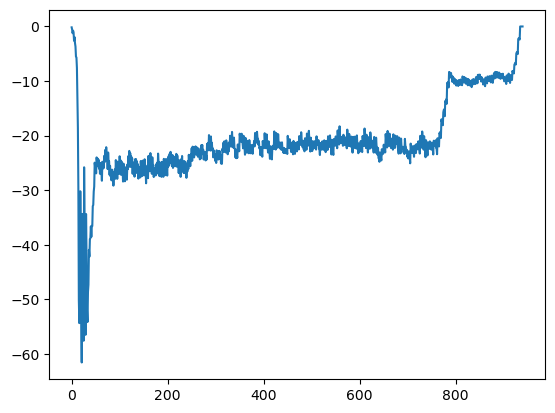

In [20]:
plt.plot(final_reward)
plt.show()

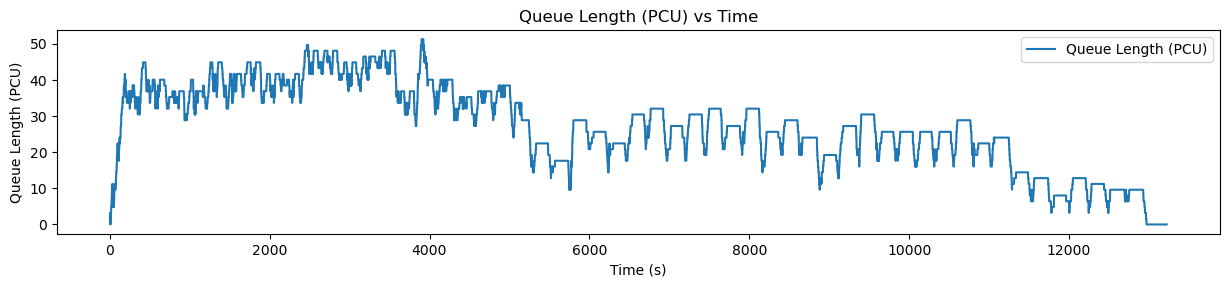

In [28]:
plt.figure(figsize=(15, 9))
plt.subplot(3, 1, 1)
plt.plot(times, [sum(queue) for queue in queue_lengths_PCU_list], label='Queue Length (PCU)')
plt.title('Queue Length (PCU) vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Queue Length (PCU)')
plt.legend()
plt.show()

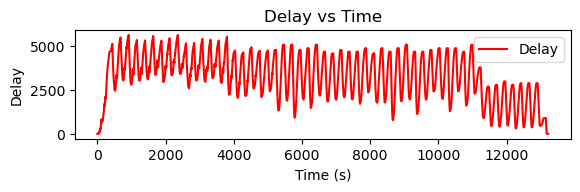

In [29]:
plt.subplot(3, 1, 1)
plt.plot(times, delays, label='Delay', color='red')
plt.title('Delay vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Delay')
plt.legend()
plt.show()

In [13]:
build_model = agent._build_model()

build_model.save('trained_model.keras')